In [1]:
import os
import sys
import json
import pickle
import gzip
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
from importlib import reload
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': False, 'svg.fonttype': 'none' }
plt.rcParams.update(new_rc_params)
import biock
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from biock.plot._plot import set_spines, get_figure_size

In [2]:
ONEHOT = np.concatenate((np.zeros((6, 4), dtype=np.int8), np.diag(np.ones(4, dtype=np.int8))))
# print(ONEHOT)

In [3]:
# load results generated by `scripts/fetch_embed_cons.py`
results = pickle.load(open("./embed_cons.pkl", "rb")) 

In [4]:
for k, v in results.items():
    print(k, v.shape)

ids_extend (1000, 1530)
splicebert (1000, 510, 512)
splicebert-human (1000, 510, 512)
phastcons (1000, 510)
phylop (1000, 510)
annotation (1000, 510, 12)


In [4]:
## load sequences(ids_extend), conservation scores(phastcons, phylop), 
##   and pre-computed nucleotide embeddings (SpliceBERT, SpliceBERT-Human)

results = pickle.load(open("./embed_cons.pkl", "rb")) # use samples
results["ids"] = list()
flanking = 250
for i in tqdm(range(results["ids_extend"].shape[0])):
    tmp = list()
    for p in range(510, 1020):
        substr = ONEHOT[results["ids_extend"][i, p-flanking:p+1+flanking]].reshape(-1).astype(np.int8)
        tmp.append(substr)
    tmp = np.stack(tmp)
    results["ids"].append(tmp)
results["ids"] = np.stack(results["ids"])
del results["ids_extend"]
for k, v in results.items():
    if v.ndim > 2:
        dim = v.shape[-1]
        v = v.reshape(-1, dim)
    else:
        v = v.reshape(-1)
    results[k] = v
ids, h1, h2, phastcons, phylop, annotation = [results[k] for k in ["ids", "splicebert", "splicebert-human", "phastcons", "phylop" ,"annotation"]]
keep = np.where((~np.isnan(phastcons)) & (~np.isnan(phylop)))[0]
ids = ids[keep]
h1 = h1[keep] # SpliceBERT
h2 = h2[keep] # SpliceBERT-human
phastcons = phastcons[keep]
phylop = phylop[keep]
annotation = annotation[keep]
print(ids.shape, h1.shape, h2.shape, phastcons.shape, phylop.shape, annotation.shape)

100%|██████████| 1000/1000 [00:05<00:00, 194.84it/s]


(506269, 2004) (506269, 512) (506269, 512) (506269,) (506269,) (506269, 12)


In [5]:
print(ids.shape, h1.shape, h2.shape)

(506269, 2004) (506269, 512) (506269, 512)


In [6]:
# normalize SpliceBERT and SpliceBERT-human embeddings
h1 = (h1 - np.mean(h1, axis=0, keepdims=True)) / np.std(h1, axis=0, keepdims=True) # SpliceBERT
h2 = (h2 - np.mean(h2, axis=0, keepdims=True)) / np.std(h2, axis=0, keepdims=True) # SpliceBERT-human

In [7]:
np.random.rand(2020)

# split train and test
in_train = np.random.rand(ids.shape[0]) > 0.2
print(biock.count_items(in_train, fraction=True))
is_train = np.where(in_train)[0]
is_test = np.where(~in_train)[0]
print(len(is_train), len(is_test))

[[False, 101339, 0.2], [True, 404930, 0.8]]
404930 101339


In [8]:
# make labels
labels = np.zeros_like(phastcons)
labels[np.where(phastcons >= 0.8)[0]] = 1
print(biock.count_items(labels, fraction=True))

[[0.0, 476963, 0.942], [1.0, 29306, 0.058]]


In [9]:
max_iter = 1000

from sklearn.linear_model import LogisticRegression
lr_onehot = LogisticRegression(max_iter=max_iter)
lr_vert = LogisticRegression(max_iter=max_iter)
lr_human = LogisticRegression(max_iter=max_iter)

In [12]:
# if os.path.exists("./mlm2cons_models.pkl"):
#     with open("./mlm2cons_models.pkl", "rb") as f:
#         lr_onehot, lr_vert, lr_human = pickle.load(f)
# else:
print("onehot")
lr_onehot.fit(ids[is_train], labels[is_train])
onehot_lr = lr_onehot.predict_proba(ids[is_test])[::, 1]
print(roc_auc_score(labels[is_test], onehot_lr), average_precision_score(labels[is_test], onehot_lr))

print("vert")
lr_vert.fit(h1[is_train], labels[is_train])
vert_lr = lr_vert.predict_proba(h1[is_test])[::, 1]
print(roc_auc_score(labels[is_test], vert_lr), average_precision_score(labels[is_test], vert_lr))

print("human")
lr_human.fit(h2[is_train], labels[is_train])
human_lr = lr_human.predict_proba(h2[is_test])[::, 1]
print(roc_auc_score(labels[is_test], human_lr), average_precision_score(labels[is_test], human_lr))

pickle.dump((lr_onehot, lr_vert, lr_human), open("./mlm2cons_models.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

onehot
0.5323226358213009 0.06715877990392737
vert
0.8375523959631377 0.35306513534206085
human
0.7918091638000315 0.25540185268308924


In [13]:
# onehot_lr = lr_onehot.predict_proba(ids[is_test])[:, 1]
# print(roc_auc_score(labels[is_test], onehot_lr), average_precision_score(labels[is_test], onehot_lr))
# vert_lr = lr_vert.predict_proba(h1[is_test])[:, 1]
# print(roc_auc_score(labels[is_test], vert_lr), average_precision_score(labels[is_test], vert_lr))
# human_lr = lr_human.predict_proba(h2[is_test])[:, 1]
# print(roc_auc_score(labels[is_test], human_lr), average_precision_score(labels[is_test], human_lr))

In [14]:
import seaborn as sns

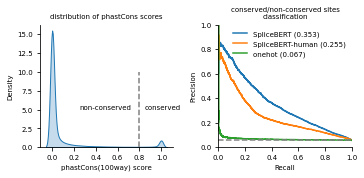

In [15]:
# set title/axes/legend font size
fs = 7
plt.rcParams['font.size'] = fs
plt.rcParams['axes.titlesize'] = fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['legend.fontsize'] = fs
plt.rcParams['figure.titlesize'] = fs

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=get_figure_size(0.6, 0.6 * 0.5))
ax = axs[0]
# _ = ax.hist(cons_scores['cons'].numpy(), bins=400)
# _ = ax.hist(phastcons, bins=1000)
sns.kdeplot(phastcons, ax=ax, fill=True)
# ax.hist(phastcons, bins=100)
ax.vlines(0.8, 0, 10, color='grey', linestyle='--')
# annotate "unconserved" region (phastCons < 0.8)
ax.text(x=0.25, y=5, s="non-conserved", color='k', fontsize=fs, rotation=0)
ax.text(x=0.85, y=5, s="conserved", color='k', fontsize=fs, rotation=0)

# sns.distplot(phastcons, ax=ax, kde=True)
ax.set_xlabel("phastCons(100way) score")
ax.set_xticks(np.arange(0, 1.1, 0.2))
set_spines(ax)
ax.set_title("distribution of phastCons scores")
# ax.set_aspect('equal')

ax = axs[1]
p, r, _ = precision_recall_curve(labels[is_test], vert_lr)
ax.plot(r, p, label="SpliceBERT ({:.3f})".format(average_precision_score(labels[is_test], vert_lr)))

p, r, _ = precision_recall_curve(labels[is_test], human_lr)
ax.plot(r, p, label="SpliceBERT-human ({:.3f})".format(average_precision_score(labels[is_test], human_lr)))

p, r, _ = precision_recall_curve(labels[is_test], onehot_lr)
ax.plot(r, p, label="onehot ({:.3f})".format(average_precision_score(labels[is_test], onehot_lr)))

ax.legend(frameon=False)
ax.hlines(xmin=0, xmax=1, y=labels[is_test].sum() / len(is_test), color='grey', linewidth=1.5, linestyle='--')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)
ax.set_title("conserved/non-conserved sites\nclassification")
set_spines(ax)

plt.tight_layout()

plt.savefig("pred_cons.svg")
plt.savefig("pred_cons.jpg", dpi=600)